In [27]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 5)

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

from pprint import pprint
from time import time

import os
import pickle

# Optimal Feature Set for Classification

Try and determine the optimal number of genes needed for accurate classification, what genes those are, and hyper parameters to improve the classification task (tissue classification).

In [5]:
exp_dir = '/mnt/rna-seq-analysis/rna-seq-analysis/data/tissue-pairs'
tissues = os.listdir(exp_dir)
tsv = 'combined-gtex-tcga-counts-protein-coding.tsv'
exp_df = pd.concat([pd.read_csv(os.path.join(exp_dir, t, tsv), sep='\t', index_col=0) for t in tissues], axis=1)
# Remove dupes
exp_df = exp_df.T.groupby(level=0).first().T
# Subset by normal / tumor samples
samples = [x for x in exp_df.columns if x.startswith('GTEX') or (x.endswith('01') or x.endswith('11'))]
exp_df = exp_df[samples]
# Transpose so genes (features) are columns
exp_df = exp_df.T
ln_df = exp_df.apply(lambda x: np.log2(x + 1))

# Get Y
tissue_map = pickle.load(open('../../data/tissue_map.pickle', 'rb'))
y = np.array([tissue_map[x] for x in exp_df.index])

In [6]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

In [ ]:
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=svc, step=2000, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(ln_df, y)

Optimal number of features : 3797


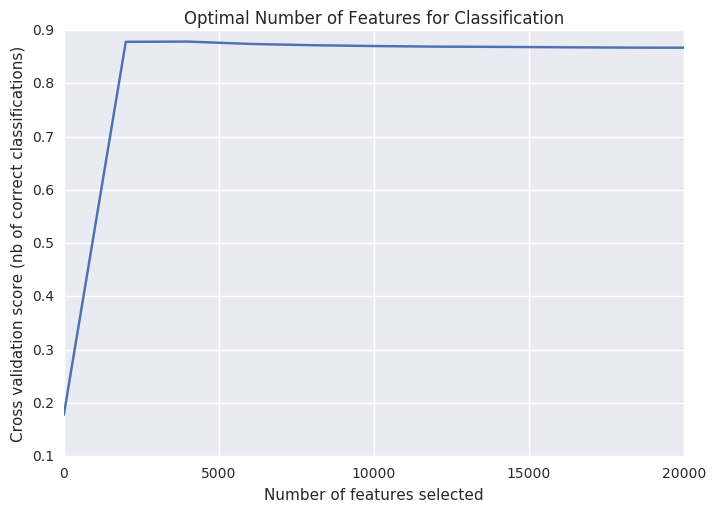

In [11]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot([x * 2000 for x in range(len(rfecv.grid_scores_))], rfecv.grid_scores_)
plt.title('Optimal Number of Features for Classification')
plt.show()

Select top 4,000 features

In [33]:
skb = SelectKBest(chi2, k=3797)

In [34]:
new = skb.fit_transform(ln_df, y)

In [38]:
Pipeline?

In [44]:
pipe = Pipeline([
    ('reduce_dim', SelectKBest(chi2, k=4000)),
    ('classify', LinearSVC())
])

C_OPTIONS = [0.1, 1, 10, 100, 1000]
param_grid = {
        'classify__C': C_OPTIONS
    }


grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid, verbose=1)

Print some info

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, new, y, n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


In [39]:
print np.mean(scores), np.std(scores)

0.906437939365 0.0517620233563


In [45]:
print "Performing grid search..."
print "pipeline:", [name for name, _ in pipe.steps]
print "parameters:"
pprint(param_grid)
t0 = time()
grid.fit(ln_df, y)
print "done in %0.3fs" % (time() - t0)
print

print "Best score: %0.3f" % grid.best_score_
print "Best parameters set:"
best_parameters = grid.best_estimator_.get_params()
try:
    for param_name in sorted(param_grid.keys() + param_grid.keys()):
        print "\t%s: %r" % (param_name, best_parameters[param_name])
except:
    pass

Performing grid search...
pipeline: ['reduce_dim', 'classify']
parameters:
{'classify__C': [0.1, 1, 10, 100, 1000]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


done in 145.633s

Best score: 0.908
Best parameters set:
	classify__C: 1
	classify__C: 1


In [46]:
grid.cv_results_

{'mean_fit_time': array([ 45.54472001,  53.36433363,  56.26680525,  54.00561078,  47.44371208]),
 'mean_score_time': array([ 0.26331162,  0.23001067,  0.18236105,  0.16056196,  0.15830533]),
 'mean_test_score': array([ 0.90813697,  0.90822901,  0.90822901,  0.90795287,  0.90795287]),
 'mean_train_score': array([ 1.,  1.,  1.,  1.,  1.]),
 'param_classify__C': masked_array(data = [0.1 1 10 100 1000],
              mask = [False False False False False],
        fill_value = ?),
 'params': ({'classify__C': 0.1},
  {'classify__C': 1},
  {'classify__C': 10},
  {'classify__C': 100},
  {'classify__C': 1000}),
 'rank_test_score': array([3, 1, 1, 4, 4], dtype=int32),
 'split0_test_score': array([ 0.84899421,  0.84954533,  0.84871866,  0.84816754,  0.84816754]),
 'split0_train_score': array([ 1.,  1.,  1.,  1.,  1.]),
 'split1_test_score': array([ 0.97265193,  0.97237569,  0.97320442,  0.97292818,  0.97292818]),
 'split1_train_score': array([ 1.,  1.,  1.,  1.,  1.]),
 'split2_test_score': arra

Plot

In [48]:
LinearSVC?

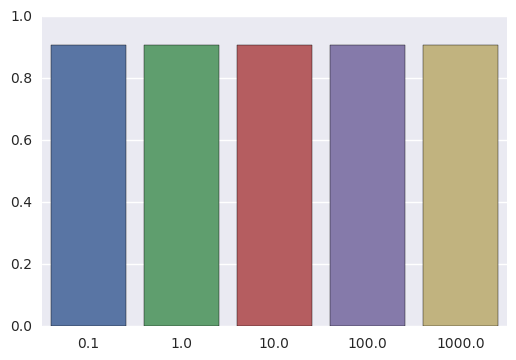

In [47]:
sns.barplot(x=C_OPTIONS, y=grid.cv_results_['mean_test_score'])
plt.xlabel('Penalty Parameter C (hyperparameter of LinearSVC)')
plt.yla

In [29]:
# mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
# mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
# mean_scores = mean_scores.max(axis=0)
# bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)
plt.figure()
COLORS = 'bgrcmyk'
reducer_scores = ['LinearSVC']
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Tumorous classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()
plt.savefig('dataset_features.png')

NameError: name 'N_FEATURES_OPTIONS' is not defined